# DTU 46500 :  Assignment 1
## Statistical extrapolation for Extreme Winds    (2022)
#### Fitting extreme distributions, uncertainty in fitting (including sample-length)
> python note: A very convenient method to work with tabular data is the dataframes made available by the pandas package. However, in this particular exercise we don't specifically need dataframes as the amount of work on tabular data is limited to the filtering part. 
For simplicity we will wait with introducing the dataframes to a future exercise, and we will work with numpy arrays.

In [2]:
####################################
# Special code for Jupyter Notebook
####################################
# Show plots in the notebook
%matplotlib inline 

# Automatically reload any packages that changed
%load_ext autoreload
%autoreload 2

# Display multiple arguments
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np
import datetime
import scipy as sp
import matplotlib.pyplot as plt

In [4]:
Data = np.genfromtxt('./../2_random_extreme/Hovsore2004to2020_U+dir.csv',delimiter=',')
Dnames = ['Timestamp','Wsp','MeanDir']

In [5]:
# CREATE A DATETIME ARRAY SO WE CAN USE ∆T for removing bad data
T = np.empty(Data[:,0].shape, dtype = datetime.datetime) # Empty numpy array of type datetime
for i in range(len(Data[:,0])):
    T[i] = datetime.datetime.strptime(str(Data[i,0].astype('int64')),'%Y%m%d%H%M')
DeltaT = np.diff(T)

In [6]:
DeltaT

array([datetime.timedelta(seconds=600), datetime.timedelta(seconds=600),
       datetime.timedelta(seconds=600), ...,
       datetime.timedelta(seconds=600), datetime.timedelta(seconds=600),
       datetime.timedelta(seconds=600)], dtype=object)

Insert reasonable values for minimum U to consider, maximum reasonable U (i.e. to avoid instrumental/data errors), and maximum acceptable jump in 10-minute mean windspeed from one record to the next: 

In [7]:
LowestWindSpeed = 0.5 # find something 
CrazyWind = 228/3.6 # highest recorded in europe, alto de orduna
maxDeltaU10min = 10. # maximum change of data between two 10 minute ranges

In [8]:
# CREATE data-selection "masks" (by using Boolean T/F arrays)

WspOK = ((Data[:,1] > LowestWindSpeed)&(Data[:,1] < CrazyWind)) # Boolean (T or F): reject unrealistic wind speeds

DeltaU = np.diff(Data[:,1])
dU10min = np.empty(DeltaU.shape,dtype = 'float')
for i in range(len(DeltaU)):
    dU10min[i] = DeltaU[i]/(DeltaT[i].seconds/600) 
DeltaUOK = (DeltaU > -maxDeltaU10min) & (DeltaU < maxDeltaU10min) 

OK1 = (WspOK[0:-1]==True) & (DeltaUOK == True)
OK2 = (WspOK[1:]==True) & (DeltaUOK == True)
OK1 = np.append(OK1,True)
OK2 = np.insert(OK2,0,True)

DataOK = OK1 & OK2 # Final filter in terms of a Boolean array

In [9]:
# APPLY FILTERS AND COMPUTE YEAR/MONTH VALUES 

T = T[DataOK]
Timestamp = Data[DataOK,0]
Wsp = Data[DataOK,1]
wdir = Data[DataOK,2]

# Compute year and month
Year = np.floor(Timestamp/1e8).astype('int64')
Month = np.floor(np.mod(Timestamp,1e8)/1e6).astype('int64')
#Day = np.floor(np.mod(Timestamp,1e6)/1e4).astype('int64')
#Hour = np.floor(np.mod(Timestamp,1e4)/1e2).astype('int64')
#Minute = np.floor(np.mod(Timestamp,1e2)/1).astype('int64')

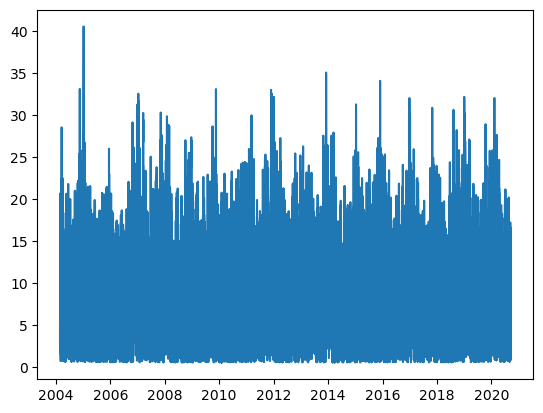

In [10]:
# plot the filtered data to check it:
plt.plot(T,Wsp)
plt.show()

In [11]:
# COMPUTE ANNUAL MAXIMA

Years = np.unique(Year) # yields the unique values of years
nyears = np.max(Years) - np.min(Years) # yields the number n of years

Umax = np.empty(nyears,dtype = 'float') # initialize an empty array
## since data starts in October, make each "year" start then
for i in range(nyears):
    CurrentPeriod = ((Year==Years[i]) & (Month >= 10)) | ((Year == (Years[i]+1)) & (Month < 10))
    Umax[i] = max(Wsp[CurrentPeriod])

# [1a]
### GUMBEL FIT - METHOD OF Probability-weighted moments (PWM)
Use the formulae from class to compute $\alpha$ and $\beta$ from $b_0$ and $b_1$ using PWM. 

Then use $\{\alpha,\beta\}$ to get $V_{50}$. 

You'll do this a number of times; 
- first, based on the whole dataset, 
- then again, using 2-year non-overlapping segments you'll find 7 "two-year" values of $\{\alpha,\beta,V_{50}\}$. 

The framework for code below helps you start out.

You'll also need to **answer quantitatively: "how well does this follow a Gumbel distribution!?" for both cases.**  
Try to quantify the variation of using only 2-year periods; how does this compare to theoretical expectation? 

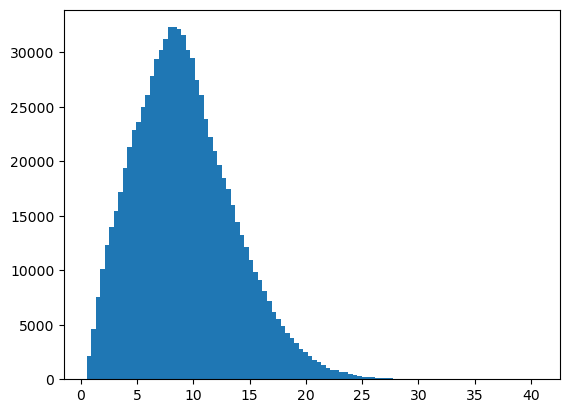

In [12]:
fig1 = plt.figure()
axs1 = plt.gca()
hist1 = axs1.hist(Wsp,100)

In [11]:
UmaxSorted = np.sort(Umax) # 1. Sort by U by value
N = len(UmaxSorted)
gamma = 0.577 # euler mascheroni np.euler_gamma

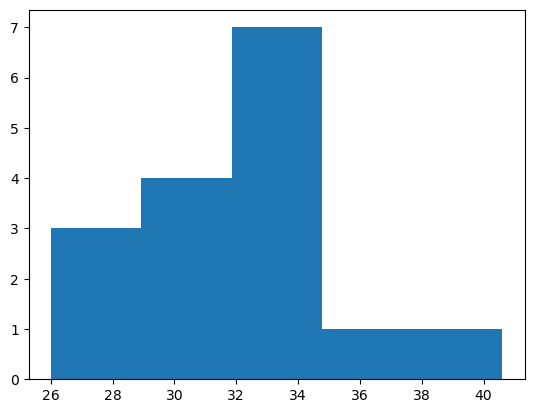

In [12]:
# Create a Histogram of the 1y max values to get a grasp of the data / distribution
fig1 = plt.figure()
axs1 = plt.gca()
hist1 = axs1.hist(UmaxSorted,5)

In [13]:
b0PWM = (1/N) * np.sum( UmaxSorted ) #calc b0 value first parameter

In [14]:
#----> calculate the parameters b0 and b1 for the PWM method - second parameter

b0PWM = (1/N) * np.sum( UmaxSorted ) #calc b0 value first parameter
if False: # old stuff 
    b1PWM = 0
    for i in range(1,N):
        b1PWM =((i-1) /(N-1) ) * UmaxSorted[i]
    b1PWM = (1/N)*b1PWM
    b1PWM
    
# This appproach for b1PWM is working:
index_list = np.arange(0,16)
b1PWM = np.sum((1/((N-1)*N) * index_list*UmaxSorted ))
print(f'b1PWM is: {b1PWM}')

b1PWM is: 16.815586121877033


In [15]:
alphaPWM = (2*b1PWM - b0PWM) / np.log(2)  # ususally between 1-3 (said in the lecture)
betaPWM = b0PWM - gamma*alphaPWM          # ususally between 10 to 20 (said in the lecture)

In [16]:
V50PWM = betaPWM + alphaPWM*np.log(50)    # yields 50 year 

In [17]:
print('PWM: V50= '+str(V50PWM.round(1))+' m/s; alpha='+str(alphaPWM.round(2))+', beta='+str(betaPWM.round(1))+' m/s')

PWM: V50= 41.0 m/s; alpha=2.8, beta=30.1 m/s


In [18]:
# redo for different dataset lengths
for i in range(nyears):
    CurrentPeriod = ((Year==Years[i]) & (Month >= 10)) | ((Year == (Years[i]+1)) & (Month < 10))
    Umax[i] = max(Wsp[CurrentPeriod])
    
N_lengths
U_data_var_length = [ for i in np.linspace(0,,N_lengths)]# list of datasets with variable lengths 
for U_list in []
    UmaxSorted = np.sort(Umax)
    b0PWM = np.sum( (1/len(UmaxSorted))*UmaxSorted ) 
    #b1PWM = np.sum( (1/len(UmaxSorted))*(/)*UmaxSorted ) 
    b1PWM = 0
    N = len(UmaxSorted)
    gamma = 0.577
    for i in range(N):
        b1PWM = (1/N) * ((i-1) /(N-1) ) * UmaxSorted[i]
    alphaPWM = (2*b1PWM - b0PWM) / np.log(2)
    betaPWM = b0PWM - gamma*alphaPWM
    V50PWM = betaPWM + alphaPWM*np.log(50) # yields 50 year 
#print('PWM: V50= '+str(V50PWM.round(1))+' m/s; alpha='+str(alphaPWM.round(2))+', beta='+str(betaPWM.round(1))+' m/s')

SyntaxError: invalid syntax (200304841.py, line 7)

## GUMBEL FIT - V50 from another method
Now use another method (of your choice) to calculate $V_{50}$ (e.g. max-likelihood, ACER, etc.). <br>
How well does this fit the Gumbel PDF (or CDF)?

 - Max likelihood method chosen

In [47]:
### Different Methods: 

### Using MLE for Gumbel and Weibull
from scipy import optimize, stats #imported here for portability

Wsp_sorted = np.sort(Wsp) #Rank the windspeeds

#Gumbel 
# Gumbel likelihood for umaxsorted --- > this is a working approach!   
gumbel_likelihood_max = lambda theta :-np.sum( np.log( abs(sp.stats.gumbel_r.pdf(UmaxSorted,loc=theta[0],scale=theta[1]) ) )) # Definition of the negative log-likelihood function; Wsp is the windspeed
gumbel_optimum_max = optimize.minimize(gumbel_likelihood_max,[30,3]) # Minimization to find the optimal distribut=30.1 m/s


# As the Gumbel distribution doesn't look to bad, does Weibull work as well? 
weibull_likelihood = lambda theta: -np.sum(np.log(sp.stats.weibull_min.pdf(UmaxSorted,c=theta[0],scale=theta[1])))
weibull_optimum = optimize.minimize(weibull_likelihood,[1,1])

#gumbel plot as (i/N+1) uses wsp sorted again -> does this work ??? 
#gumbel_likelihood2 = lambda theta: -np.sum(np.log(stats.gumbel_r.pdf(Wsp_sorted,scale = theta[1], loc = theta[0]))) # Definition of the gumbel function
#gumbel_opt2 = sp.optimize.minimize(gumbel_likelihood2,[10,5]) # Minimization to find the optimal distribution parameters

#Frechet implementation - > this is not that simple. maybe delete it or extend
if False: 
    def frechet_cdf(x,alpha,scale,loc=0): 
        p = np.exp(-((x-loc)/scale)**(-alpha))
        return p
    def frechet_pdf(x,alpha,scale,loc=0): #implementation like this does not really work
        p = (alpha/scale) * ((x-loc)/scale)**(-1-alpha)
        return p 
    frechet_likelihood = lambda theta: -np.sum(np.log(frechet_pdf(Wsp_sorted,theta[0],theta[1]))) # Definition of the frechet mle function
    frechet_opt = sp.optimize.minimize(frechet_likelihood,[10,5]) # Minimization to find the optimal distribution parameters

print(f' PWM for the Gumbel dist. yields alpha= {alphaPWM}, and beta= {betaPWM}')
print(f' MLE for the Gumbel dist. yields alpha= {gumbel_optimum_max.x[1]}, and beta= {gumbel_optimum_max.x[0]}')
print(f' MLE for the Weibull dist. yields c = {weibull_optimum.x[0]}, and scale= {weibull_optimum.x[1]}')

 PWM for the Gumbel dist. yields alpha= 2.798058243307122, and beta= 30.077226454975012
 MLE for the Gumbel dist. yields alpha= 3.0910861220777983, and beta= 30.04518146786341
 MLE for the Weibull dist. yields c = 8.885313539228601, and scale= 33.26638445925465


Text(0.5, 0, '$U_{max}$')

Text(0, 0.5, 'p(u)')

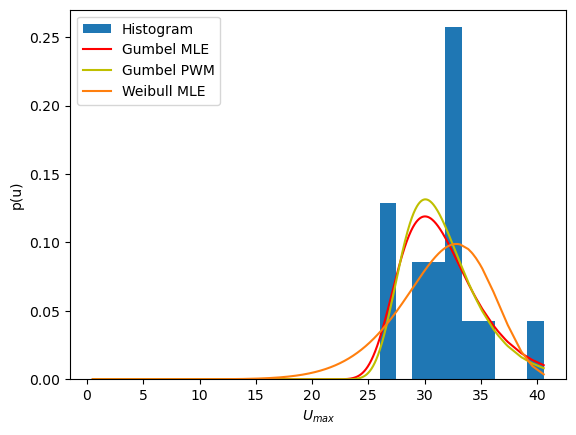

In [36]:
# Compare to data ! 
if False: #This is a histogram to look at 
    fig10 = plt.figure()
    axs1 = plt.gca()
    hist1 = axs1.hist(UmaxSorted,5)
    plt.xlabel('Max wind speed Umax [m/s]')
    plt.ylabel('Number of occurrences')
    plt.title('Histogram of the 1year max windspeeds at Høvsøre')
    plt.show()

# Plotting of the estimated distributions (pdfs)
fig1 = plt.figure()
axs1 = plt.gca()
hist1 = axs1.hist(UmaxSorted,10, density=True,stacked=True,label="Histogram")
#plt.plot(Wsp_sorted,stats.gumbel_r.pdf(Wsp_sorted,loc = gumbel_optimum.x[0],scale = gumbel_optimum.x[1]),'--r')
plt.plot(Wsp_sorted,stats.gumbel_r.pdf(Wsp_sorted,loc = gumbel_optimum_max.x[0],scale = gumbel_optimum_max.x[1]),'r',label="Gumbel MLE")
#plt.plot(Wsp_sorted,stats.gumbel_r.pdf(Wsp_sorted, scale=gumbel_opt2.x[1],loc = gumbel_opt2.x[0]),'--r')
plt.plot(Wsp_sorted,stats.gumbel_r.pdf(Wsp_sorted,loc = betaPWM, scale=alphaPWM ),color="y",label="Gumbel PWM")
plt.plot(Wsp_sorted,stats.weibull_min.pdf(Wsp_sorted,weibull_optimum.x[0],scale=weibull_optimum.x[1]),label="Weibull MLE")
plt.xlabel(r"$U_{max}$")
plt.ylabel("p(u)")
plt.legend()

In [51]:
# Finally, calculate V50 estimates
#Calculate V50 values for Gumbell Disribution from the equation in the slides
V50_mle = gumbel_optimum_max.x[0] + gumbel_optimum_max.x[1]*np.log(50) # yields 50 year 
V50PWM = betaPWM + alphaPWM*np.log(50) # yields 50 year 

#get v50 from 2% approximation 
V50_weibull_mle = stats.weibull_min.ppf(.98,weibull_optimum.x[0],scale=weibull_optimum.x[1] )
V50_gumbelPWM_2 = stats.gumbel_r.ppf(.98,loc = betaPWM, scale=alphaPWM) # Sanity check: This should not differ too much ! 

# do the thumb rule as well:
V50_thumb = 5* np.mean(Wsp)

print(f'V50 for Gumbel with PWM: {V50PWM}')
print(f'V50 for Gumbel with MLE: {V50_mle}')
print(f'V50 for Weibull with MLE: {V50_weibull_mle}')
print(f'V50 for Gumbel with MLE and 2% rule: {V50_gumbelPWM_2}')
print(f'V50 for thumb rule (5* V_avg):  {V50_thumb}')

V50 for Gumbel with PWM: 41.023294673320336
V50 for Gumbel with MLE: 42.13758148919143
V50 for Weibull with MLE: 38.78623077226182
V50 for Gumbel with MLE and 2% rule: 40.9950780816911
V50 for thumb rule (5* V_avg):  46.10867496455005


Text(0.5, 1.0, 'V50 values for different Methods')

Text(0.5, 0, 'V50 [m/s]')

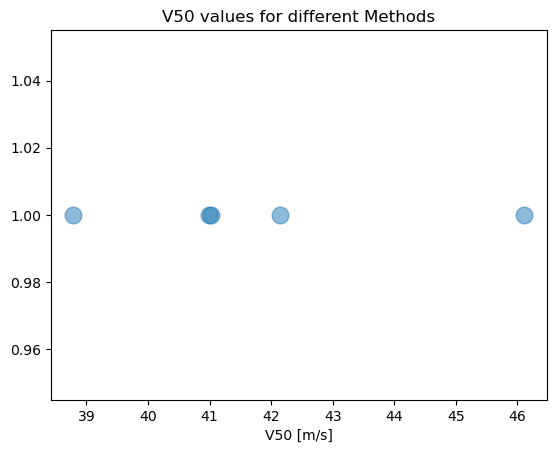

In [130]:
# make a visualization of different V50 Values as a line plot 

V50_list = [V50PWM,V50_gumbelPWM_2,V50_mle,V50_weibull_mle,V50_thumb]
label_list = ["Gumbel PWM","Gumbel PWM 2%","Gumbel MLE","Weibull MLE","Thumbrule"]
plt.plot(V50_list, [1]*len(V50_list),'o',markersize=12,alpha=.5)
plt.title("V50 values for different Methods")
plt.xlabel("V50 [m/s]")

Text(0.5, 0, 'Estimation Method')

Text(0, 0.5, '$V_{50}$ $[m/s]$')

Text(0.5, 1.0, '$V_{50} $ estimates for different using different Methods')

([<matplotlib.axis.XTick at 0x7fb111185d90>,
 [Text(0, 0, 'Gumbel PWM'),
  Text(1, 0, 'Gumbel PWM 2%'),
  Text(2, 0, 'Gumbel MLE'),
  Text(3, 0, 'Weibull MLE'),
  Text(4, 0, 'Thumbrule')])

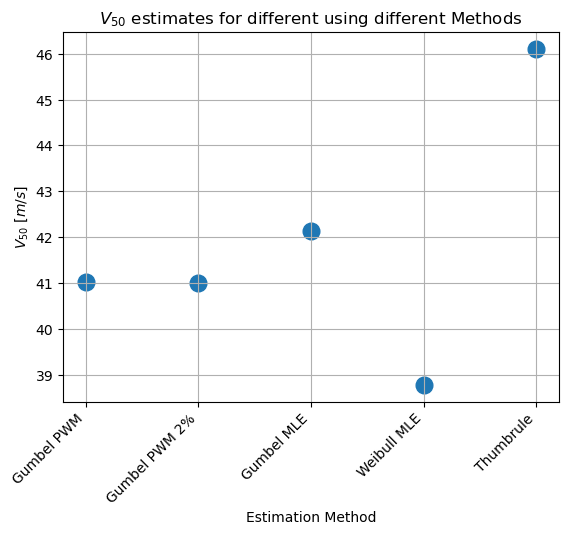

In [131]:
plt.rcParams['lines.markersize'] = 12
fig, ax = plt.subplots()
bars = ax.scatter(np.arange(len(V50_list)),V50_list)
# make it look nicer 
plt.grid("major")
ax.set_xlabel('Estimation Method')
ax.set_ylabel(r'$V_{50}$ $[m/s]$')
ax.set_title(r'$V_{50} $ estimates for different using different Methods')
plt.xticks(np.arange(len(V50_list)),rotation=45, ha="right",labels=label_list)

### Interpretation
The V50 estimates for different methods have been shown. They all end up in a similar range. 
When comparing to the 

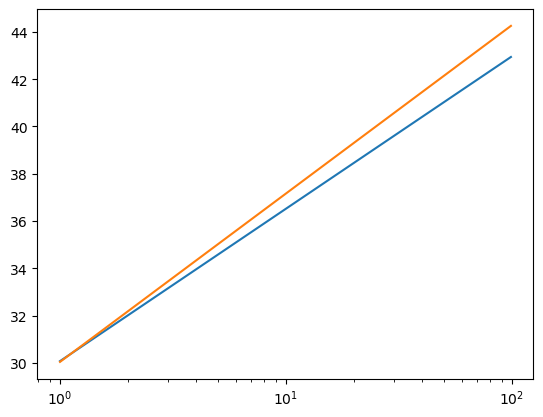

In [132]:
# Try plotting the lines from the gumbel distributions in the log plot 
# -> leave it to moritz
#plt.plot(UmaxSorted)
#plt.plot(Wsp_sorted,stats.gumbel_r.pdf(Wsp_sorted,loc = gumbel_optimum_max.x[0],scale = gumbel_optimum_max.x[1]),'--r')
uT = lambda T: betaPWM +  alphaPWM * np.log(T/1)
uT_mle = lambda T: gumbel_optimum_max.x[0] +  gumbel_optimum_max.x[1] * np.log(T/1)
x = np.arange(1,100)
plt.semilogx(x, [uT(xi) for xi in x])
plt.semilogx(x, [uT_mle(xi) for xi in x])

### KS TEST
- Try the KS test

In [133]:
############ --------->Goodness of the fits : Using the KS- test 

#What is the confidence level we need to achieve ? 99% ? 95% ? 
#--> choose 95%. According to http://www.stat.yale.edu/Courses/1997-98/101/confint.htm it is a common choice 



conf_level = .95 # % of confidence; confidence level

# do the ks test from the scipy.stats module
ks_gumbel_PWM = sp.stats.kstest(UmaxSorted, 'gumbel_r',args=(betaPWM, alphaPWM)) # ,args=(alphaPWM))
ks_gumbel_MLE = sp.stats.kstest(UmaxSorted, 'gumbel_r',args=(gumbel_optimum_max.x[0],gumbel_optimum_max.x[1]),N=16) # ,args=(alphaPWM))
ks_weibull_MLE = sp.stats.kstest(UmaxSorted, 'weibull_min',args=(weibull_optimum.x[0],weibull_optimum.x[1]),N=20)

if False: 
    print(f'KS - Results: \n Gumbel PWM: {ks_gumbel_PWM} \n \
    Gumbel MLE: {ks_gumbel_MLE} \n \
    Weibul Mle: {ks_weibull_MLE}')

#Now compare the p value with the confidence: 
# -> Hypothesis: underlying distribution is the stated one with conf of 95 % 
# Then: Hyp rejected when p < 5
#       Hyp supported when p> 5  # This is according to the examples in scipy.stats.kstest
print("Hypothesis: The Samples follow the regarding distributions with a confidence level of 95%")
if ks_gumbel_PWM[1] >(1-conf_level): 
    print(f"Goodness of Gumbel PWM fit: \t p={np.around(ks_gumbel_PWM[1],4)} is bigger than p_lim={np.around(1-conf_level,4)}, hence the hypothesis is supported. ")
else:
    print(f"Goodness of Gumbel PWM fit: \t p={np.around(ks_gumbel_PWM[1],4)} is smaller than p_lim={np.around(1-conf_level,4)}, hence the hypothesis is rejected. \n \
    The samples don't follow the distributions to the specified confidence.")

    # Same procedure for the Max likelihood estimate
if ks_gumbel_MLE[1] >(1-conf_level): 
    print(f"Goodness of Gumbel MLE fit: \t p={np.around(ks_gumbel_MLE[1],4)} is bigger than p_lim={np.around(1-conf_level,4)}, hence the hypothesis is supported. ")
else:
    print(f"Goodness of Gumbel MLE fit: \t p={np.around(ks_gumbel_MLE[1],4)} is smaller than p_lim={np.around(1-conf_level,4)}, hence the hypothesis is rejected. \n \
    The samples don't follow the distributions to the specified confidence.")

# And again for the mle weibull : 
if ks_weibull_MLE[1] >(1-conf_level): 
    print(f"Goodness of Weibull MLE fit: \t p={np.around(ks_eibull_MLE[1],4)} is bigger than p_lim={np.around(1-conf_level,4)}, hence the hypothesis is supported ")
else:
    print(f"Goodness of Weibull MLE fit: \t p={np.around(ks_weibull_MLE[1],4)} is smaller than p_lim={np.around(1-conf_level,4)}, hence the hypothesis is rejected. \n \
    The samples don't follow the distributions to the specified confidence.")    

Hypothesis: The Samples follow the regarding distributions with a confidence level of 95%
Goodness of Gumbel PWM fit: 	 p=0.6598 is bigger than p_lim=0.05, hence the hypothesis is supported. 
Goodness of Gumbel MLE fit: 	 p=0.6559 is bigger than p_lim=0.05, hence the hypothesis is supported. 
Goodness of Weibull MLE fit: 	 p=0.0 is smaller than p_lim=0.05, hence the hypothesis is rejected. 
     The samples don't follow the distributions to the specified confidence.


In [108]:
# make the log plot for U_ranked 
if False: 
    A = np.trapz(UmaxSorted)
    B = np.trapz(UmaxSorted)
    plt.plot(UmaxSorted)
    plt.plot(sp.stats.gumbel_r.cdf(UmaxSorted,betaPWM,scale=alphaPWM))

### To dp
- comparison of values 
 - IEC turb - makes a difference ? 
 - plot of different results 
 - 42.5 limit 

# 1b: Uncertainty in $V_{50}$ estimates
Using the $\alpha$-parameter you found above in [1a] using _the whole 16-year timeseries_, 
- do bootstrap sampling with many 2-year segments to get a distribution of $f_{2y}(\alpha$ and $f_{2y}(V_{50})$; 
     - what is the uncertainty in using 2-year segments, i.e., the standard deviation $\sigma_{V50_\textrm{fit 2yr}}$
- repeat this for other segment lengths (3 years, 4y...10y), to get (fit) a relation for $\sigma^2_{V50}(T_\textrm{segment})$
- How does your relation for $\sigma^2_{V50}(T_\textrm{segment})$ compare to the Ott(2011) expression for $\sigma^2_{U_T}$? 
    - ignoring $\beta$, how much variation in $\alpha$ (e.g. $\sigma_\alpha/\langle\alpha\rangle$) does your $\sigma^2_{V50}(T_\textrm{segment})$ correspond to? 

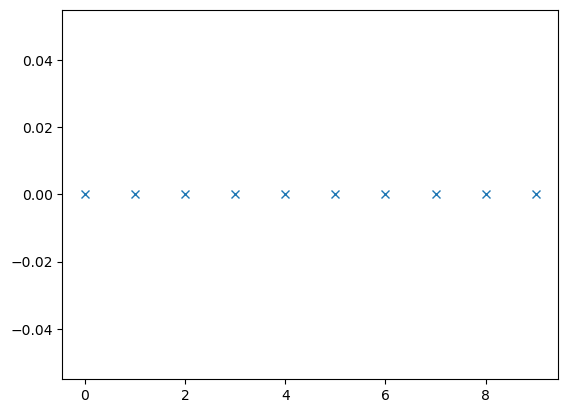

In [51]:
import numpy as np
import matplotlib.pyplot as pp
val = 0. # this is the value where you want the data to appear on the y-axis.
ar = np.arange(10) # just as an example array
pp.plot(ar, np.zeros_like(ar) + val, 'x')
pp.show()
